## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl

from scipy.signal import savgol_filter

mpl.rc('font', family='Georgia')

from generalist_cmaes_config import ENEMY_SETS, NGEN

%load_ext autoreload
%autoreload 2

NGEN = 100

Folders for loading data for each algorithm

In [2]:
CMAES_DATAPATH = os.path.join('data', 'cmaes')
NEAT_DATAPATH = os.path.join('data', 'neat')

Unpack the enemy sets

In [3]:
ENEMY_SET_1 = ENEMY_SETS['set_1']
ENEMY_SET_2 = ENEMY_SETS['set_2']

Folder for saving the results (figures)

In [4]:
FIGURE_PATH = os.path.join('figures', 'generalist')
os.makedirs(FIGURE_PATH, exist_ok=True)

## 0. Competition submission

Since we obtained our highest total gain with data which we did not use for our final experiments, we gather that data here.

In [5]:
gains = np.load(os.path.join(CMAES_DATAPATH, "set_1", "hp_crit_mean_of_max", "best_gains.npy"))
print(gains)

optimal_index = np.argmax(gains)

[-116.6   50.8   30.    64.4 -112.   -38.4  -82.4   31.8 -154.6  272.4]


In [6]:
best_individuals = np.load(os.path.join(CMAES_DATAPATH, "set_1", "hp_crit_mean_of_max", "train_best_individuals.npy"))
best_individuals[-1].shape

from generalist_cmaes_best_gains import create_singlemode_environment
from generalist_cmaes_config import CONTROLLER

total_gain = 0.0

for enemy in range(1,9):
     env = create_singlemode_environment('', enemy, CONTROLLER)
     env.player_controller.set_weights(best_individuals[optimal_index], 10)
     _, pl, el, _ = env.play()
     print(f"Gain #{enemy} = {np.round(pl - el, 1)}, player energy = {pl}, enemy energy = {el}")
     total_gain += pl - el

print(f"Total gain = {np.round(total_gain, 1)}")
#np.savetxt("105.txt", best_individuals[optimal_index])

pygame 2.6.0 (SDL 2.28.4, Python 3.10.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
Gain #1 = 100, player energy = 100, enemy energy = 0
Gain #2 = 68, player energy = 68, enemy energy = 0
Gain #3 = 92, player energy = 92, enemy energy = 0
Gain #4 = -70.0, player energy = 0, enemy energy = 70.0
Gain #5 = 86.8, player energy = 86.80000000000013, enemy energy = 0
Gain #6 = -70.0, player energy = 0, enemy energy = 70.0
Gain #7 = 85.6, player energy = 85.60000000000014, enemy energy = 0
Gain #8 = -20.0, player energy = 0, enemy energy = 20.0
Total gain = 272.4


## Figure 1: Fitness comparison

This figure presents a comparison of fitness of generalist agents trained with two evolutionary algorithms: CMAES and cmaes across all generations.

### Load CMAES fitness data

In [7]:
cmaes_data = np.array([
    np.load(os.path.join(CMAES_DATAPATH, "set_1", "hp_crit_mean", "train_all_fitnesses.npy"))[:,:NGEN,:],
    np.load(os.path.join(CMAES_DATAPATH, "set_2", "hp_crit_mean", "train_all_fitnesses.npy"))[:,:NGEN,:]
])

print(cmaes_data.shape)

(2, 10, 100, 58)


Obtain maximums, HOF-maximums and means of fitnesses for each generation

In [8]:
# Max fitness among individuals
cmaes_max = np.max(cmaes_data, axis=3)
print(cmaes_max.shape)

# Hall-of-fame variant instead of generational max
cmaes_hof = np.maximum.accumulate(cmaes_max, axis=2)
print(cmaes_hof.shape)

# Mean fitness among individuals
cmaes_mean = np.mean(cmaes_data, axis=3)
print(cmaes_mean.shape)

(2, 10, 100)
(2, 10, 100)
(2, 10, 100)


### Load cmaes fitness data

In [9]:
neat_data = np.array([
    np.load(os.path.join(NEAT_DATAPATH, "set_1", "all_fitnesses_static.npy")),
    np.load(os.path.join(NEAT_DATAPATH, "set_2", "all_fitnesses_static.npy"))
])

print(neat_data.shape)

(2, 10, 100, 352)


Obtain maximums and means of fitnesses for each generation

In [10]:
# Max fitness among individuals
neat_max = np.nanmax(neat_data, axis=3)
print(neat_max.shape)

# Mean fitness among individuals
neat_mean = np.nanmean(neat_data, axis=3)
print(neat_mean.shape)

(2, 10, 100)
(2, 10, 100)


### Plotting

In [11]:
def plot_mean_with_sd(ax, xx, means, sds, color="blue", label=""):
    """
    Helper function for plotting mean values with standard deviations
    """
    line = ax.plot(xx, means, color=color, linestyle="solid", lw=1.8)
    ax.fill_between(xx, means + sds, means - sds, color=color, alpha=0.2, edgecolor=color, linewidth=0.0)
    ax.plot(xx, means + sds, color=color, linestyle="solid", lw=0.5, alpha=0.5)
    ax.plot(xx, means - sds, color=color, linestyle="solid", lw=0.5, alpha=0.5)

    return line[0]

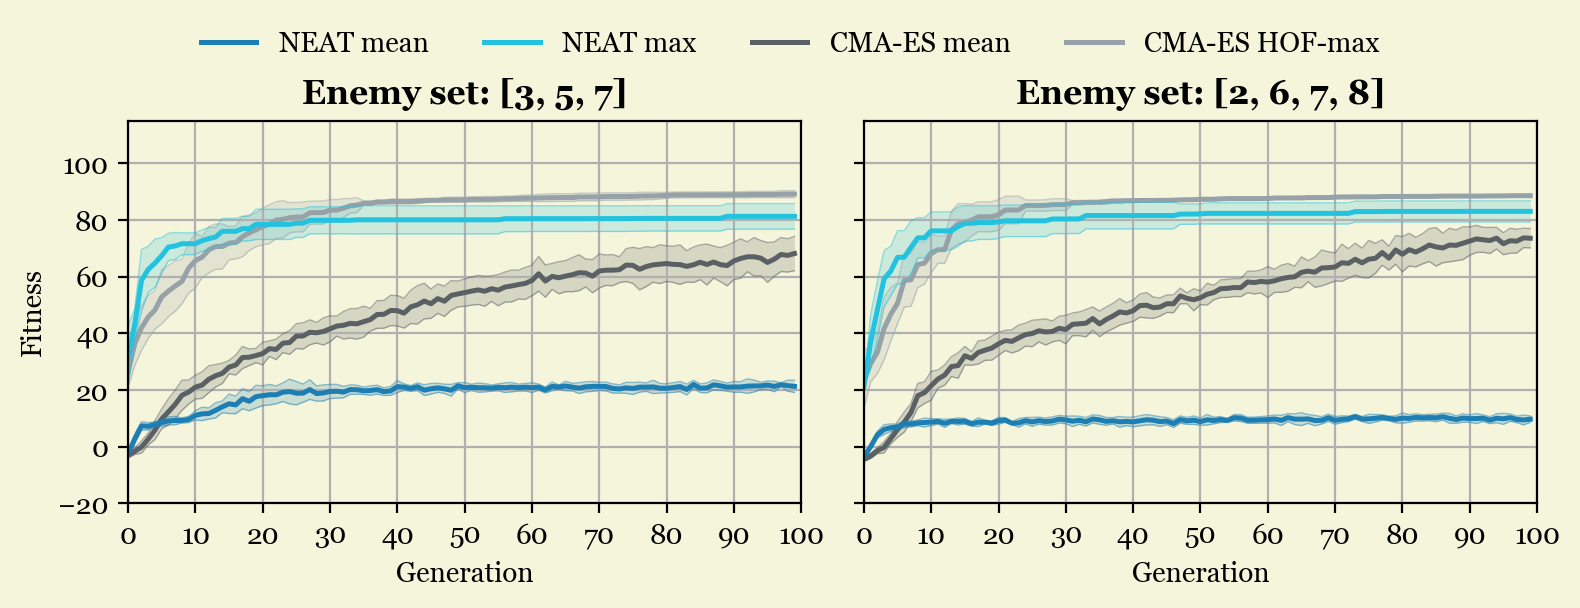

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=200, sharey=True)
fig.patch.set_facecolor('beige')

# Plot formatting
for (i, enemy_set) in enumerate([ENEMY_SET_1, ENEMY_SET_2]):
    axes[i].set_ylim(-20, 115)
    axes[i].set_yticks(np.arange(-20, 101, 20))

    axes[i].set_facecolor('beige')

    if i == 0:
        axes[i].set_ylabel("Fitness")
        
    axes[i].set_xlim(0, NGEN)
    axes[i].set_xticks(np.arange(0, NGEN + 1, 10))
    axes[i].set_xlabel("Generation")
    axes[i].set_title(f"Enemy set: {enemy_set}", weight="bold")
    axes[i].grid()

lines = []
labels = []
for i in range(2):
    #line1 = axes[i].errorbar(range(NGEN), neat_avg_mean[i], yerr=neat_sd_mean[i], alpha=0.6, lw=1.2, color="red", label="NEAT mean")
    #line2 = axes[i].errorbar(range(NGEN), neat_avg_max[i], yerr=neat_sd_max[i], alpha=0.6, lw=1.2, color="darkred", label="NEAT max")
    # line3 = axes[i].errorbar(range(NGEN), np.mean(cmaes_mean[i], axis=0), yerr=np.std(cmaes_mean[i], axis=0), alpha=0.6, lw=1.2, color="royalblue", label="CMAES mean")
    # line4 = axes[i].errorbar(range(NGEN), np.mean(cmaes_max[i], axis=0), yerr=np.std(cmaes_max[i], axis=0), alpha=0.6, lw=1.2, color="darkblue", label="CMAES max")
    # line5 = axes[i].errorbar(range(NGEN), np.mean(cmaes_hof[i], axis=0), yerr=np.std(cmaes_hof[i], axis=0), alpha=0.6, lw=1.2, color="green", label="CMAES HOF-max")

    line3 = plot_mean_with_sd(axes[i], range(100), np.mean(cmaes_mean[i], axis=0), np.std(cmaes_mean[i], axis=0), color="#5a6063", label="CMAES-mean")
    #line4 = plot_mean_with_sd(axes[i], range(NGEN), np.mean(cmaes_max[i], axis=0), np.std(cmaes_max[i], axis=0), color="#565759", label="CMAES-max")
    line4 = plot_mean_with_sd(axes[i], range(100), np.mean(cmaes_hof[i], axis=0), np.std(cmaes_hof[i], axis=0), color="#97a2a8", label="CMAES HOF-max")

    line1 = plot_mean_with_sd(axes[i], range(100), np.mean(neat_mean[i], axis=0), np.std(neat_mean[i], axis=0), color="#1d7eb3", label="NEAT-mean")
    line2 = plot_mean_with_sd(axes[i], range(100), np.mean(neat_max[i], axis=0), np.std(neat_max[i], axis=0), color="#23c2de", label="NEAT-max")

    if i == 0:
        lines.extend([line1, line2, line3, line4])
        labels.extend(["NEAT mean", "NEAT max", "CMA-ES mean", "CMA-ES HOF-max"])

fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.legend(lines, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.02), fontsize=10, frameon=False)
#fig.savefig("figures/convergence.png", dpi=400)
plt.show()

## Figure 2: Gain boxplots

### Load CMAES gain data

In [13]:
cmaes_data = np.array([
    np.load(os.path.join(CMAES_DATAPATH, "set_1", "hp_crit_mean", "best_gains.npy")),
    np.load(os.path.join(CMAES_DATAPATH, "set_2", "hp_crit_mean", "best_gains.npy"))
])

print(cmaes_data.shape)

(2, 10)


### Load NEAT gain data

In [14]:
neat_data = np.array([
    np.load(os.path.join(NEAT_DATAPATH, "set_1", "best_gains.npy")),
    np.load(os.path.join(NEAT_DATAPATH, "set_2", "best_gains.npy"))
])

print(neat_data.shape)

(2, 10)


### Get insight to see which is our best in this dataset

In [15]:
best_individuals[-1].shape
for set in neat_data:
    optimal_index = np.argmax(set)
    print(set[optimal_index], optimal_index)

for set in cmaes_data:
    optimal_index = np.argmax(set)
    print(set[optimal_index], optimal_index)

-40.399999999999196 2
-43.199999999998866 3
25.600000000000932 1
58.80000000000123 6


In [16]:
# since the highest gain is obtained by using set2 and cma-es, we load that data
best_individuals = np.load(os.path.join(CMAES_DATAPATH, "set_2", "hp_crit_mean", "train_best_individuals.npy"))
best_individuals[-1].shape

total_gain = 0.0
for enemy in range(1,9):
     env = create_singlemode_environment('', enemy, CONTROLLER)
     env.player_controller.set_weights(best_individuals[optimal_index], 10)
     _, pl, el, _ = env.play()
     print(f" #{enemy} player energy {pl}, enemy energy {el} ")
     total_gain += pl - el

print(f"Total gain = {np.round(total_gain, 1)}")
#np.savetxt("105.txt", best_individuals[optimal_index])

 #1 player energy 0, enemy energy 60.0 
 #2 player energy 58, enemy energy 0 
 #3 player energy 0, enemy energy 60.0 
 #4 player energy 0, enemy energy 80.0 
 #5 player energy 47.2000000000003, enemy energy 0 
 #6 player energy 37.60000000000028, enemy energy 0 
 #7 player energy 57.400000000000325, enemy energy 0 
 #8 player energy 58.60000000000033, enemy energy 0 
Total gain = 58.8


### Plotting

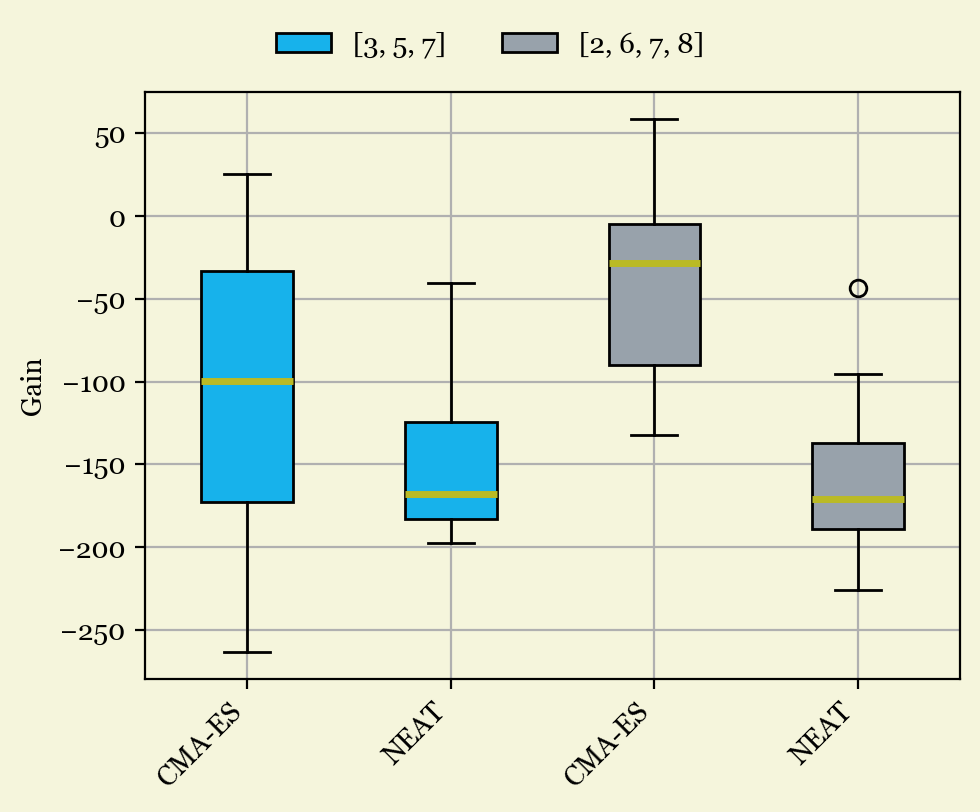

In [17]:
# Create the figure
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)
fig.patch.set_facecolor('beige')

# Group up data, corresponding labels and boxplot colors
all_gains = [cmaes_data[0], neat_data[0], cmaes_data[1], neat_data[1]]
labels = ['CMA-ES', 'NEAT', 'CMA-ES', 'NEAT']
colors = ['#17b2eb', '#17b2eb', '#98a2ab', '#98a2ab']

# Style of median line
medianprops = dict(linestyle='-', linewidth=2.5, color='#baba25')

# Create the boxplot
bplot = ax.boxplot(all_gains, patch_artist=True, medianprops=medianprops)

# Matplotlib formatting
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_facecolor('beige')
ax.set_ylabel("Gain")
ax.grid()

# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

fig.tight_layout(rect=[0, 0, 1, 0.95])

legend = fig.legend([bplot['boxes'][0], bplot['boxes'][2]], [ENEMY_SET_1, ENEMY_SET_2], loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.02), fontsize=10, frameon=False)
frame = legend.get_frame()
frame.set_facecolor('beige')
frame.set_edgecolor('beige')
fig.savefig("figures/test_gain.png", dpi=400)
plt.show()

## Figure 3: Time efficiency

#### 3.1. Time elapsed

### Read CMAES time elapsed data

In [18]:
cmaes_time = np.array([
    np.load(os.path.join(CMAES_DATAPATH, "set_1", "hp_crit_mean", "train_all_times_elapsed.npy"))[:,:NGEN],
    np.load(os.path.join(CMAES_DATAPATH, "set_2", "hp_crit_mean", "train_all_times_elapsed.npy"))[:,:NGEN]
])

# Normalize to miliseconds ????
# TODO: DELETE
cmaes_time = cmaes_time
print(cmaes_time.shape)

cmaes_cumtime = np.cumsum(cmaes_time, axis=2)
print(cmaes_cumtime.shape)

(2, 10, 100)
(2, 10, 100)


### Read NEAT time elapsed data

In [19]:
neat_time = np.array([
    np.load(os.path.join(NEAT_DATAPATH, "set_1", "all_times_elapsedstatic.npy")),
    np.load(os.path.join(NEAT_DATAPATH, "set_2", "all_times_elapsedstatic.npy"))
])

# Normalize to miliseconds
neat_time = neat_time
print(neat_time.shape)

# Cumulative time elapsed
neat_cumtime = np.cumsum(neat_time, axis=2)
print(neat_cumtime.shape)

(2, 10, 100)
(2, 10, 100)


### Plotting

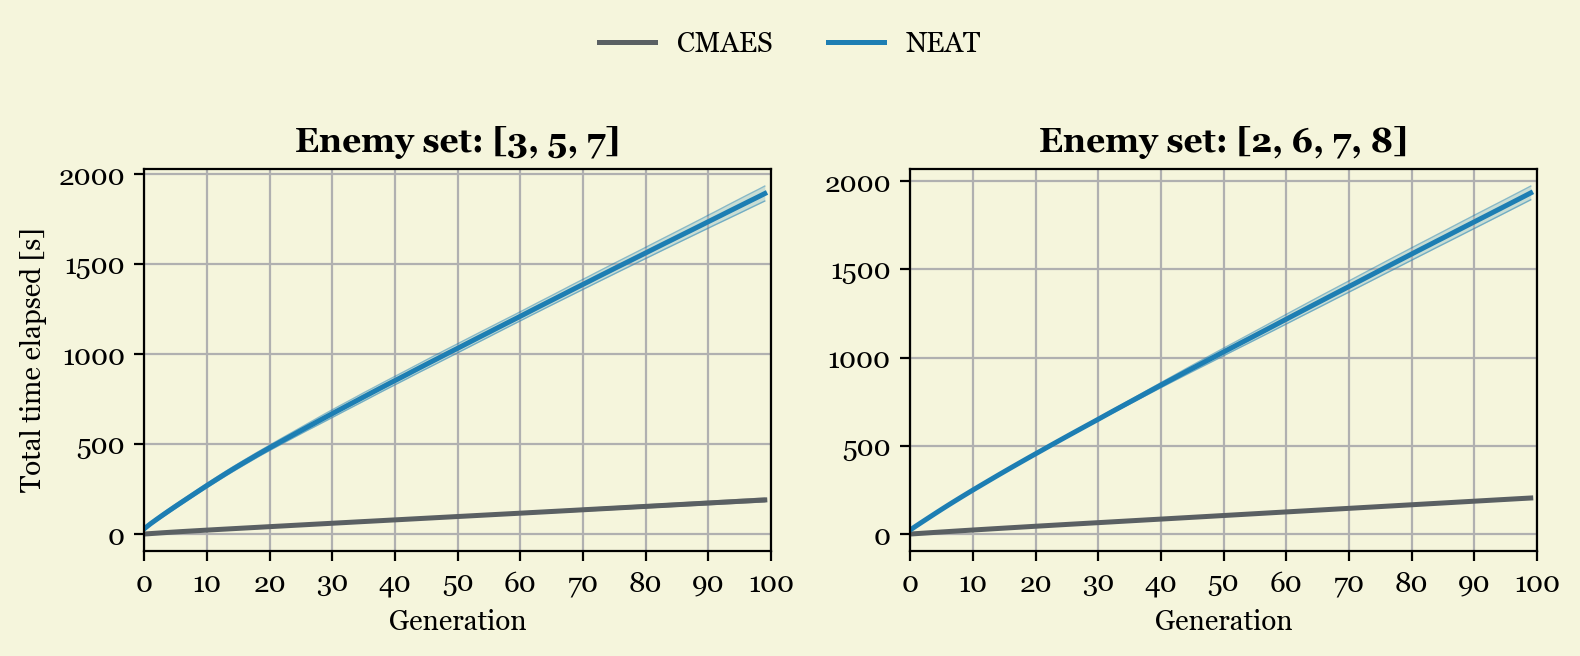

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=200)
fig.patch.set_facecolor('beige')

# Plot formatting
for (i, enemy_set) in enumerate([ENEMY_SET_1, ENEMY_SET_2]):
    # axes[i].set_ylim(-20, 115)
    # axes[i].set_yticks(np.arange(-20, 101, 20))

    axes[i].set_facecolor('beige')

    if i == 0:
        axes[i].set_ylabel("Total time elapsed [s]")
        
    axes[i].set_xlim(0, NGEN)
    axes[i].set_xticks(np.arange(0, 101, 10))
    axes[i].set_xlabel("Generation")
    axes[i].set_title(f"Enemy set: {enemy_set}", weight="bold")
    axes[i].grid()

lines = []
labels = []

for (i, enemy_set) in enumerate([ENEMY_SET_1, ENEMY_SET_2]):

    line1 = plot_mean_with_sd(axes[i], range(100), np.mean(cmaes_cumtime[i], axis=0), np.std(cmaes_cumtime[i], axis=0), color="#5a6063", label=f"CMAES: {ENEMY_SET_2}")
    line2 = plot_mean_with_sd(axes[i], range(100), np.mean(neat_cumtime[i], axis=0), np.std(neat_cumtime[i], axis=0), color="#1d7eb3", label=f"NEAT: {ENEMY_SET_2}")

    if i == 0:
        lines.extend([line1, line2])
        labels.extend([f"CMAES", f"NEAT"])

fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.legend(lines, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.10), fontsize=10, frameon=False)
# fig.savefig("figures/convergence.png", dpi=400)
plt.show()

---

#### 3.2. Time efficiency, smoothed out

#### Prepare CMAES time efficiency data

In [21]:
# Mean cumulative time
cmaes_mean_cumtime = np.mean(cmaes_cumtime, axis=1)
print(cmaes_mean_cumtime.shape)

# Differences in mean max fitness
cmaes_mean_hof = np.mean(cmaes_hof, axis=1)
cmaes_maxdiff = cmaes_mean_hof - np.roll(cmaes_mean_hof, 1, axis=1)
cmaes_maxdiff[cmaes_maxdiff < 0] = 0
print(cmaes_maxdiff.shape)

cmaes_timeeff_plotdata = []

for i in range(2):
    # Delete entries (generations) where max fitness wasn't changed
    nonzero_indices = np.nonzero(cmaes_maxdiff[i])[0]

    # Generations at which max value increased
    xx = nonzero_indices

    # Cumulative time difference
    cumtime_diff = cmaes_mean_cumtime[i,nonzero_indices] - np.roll(cmaes_mean_cumtime[i,nonzero_indices], 1)
    cumtime_diff[0] = cmaes_mean_cumtime[i,nonzero_indices[0]]

    # Calculate time efficiency
    time_eff = cmaes_maxdiff[i,nonzero_indices] / cumtime_diff

    # And smoothen it out
    yy = savgol_filter(time_eff, 10, 1)
    cmaes_timeeff_plotdata.append([xx, yy])

    print(len(xx), len(yy))

(2, 100)
(2, 100)
76 76
68 68


#### Prepare NEAT time efficiency data

In [22]:
# Mean cumulative time
neat_mean_cumtime = np.mean(neat_cumtime, axis=1)
print(neat_mean_cumtime.shape)

# Differences in mean max fitness
neat_mean_max = np.mean(neat_max, axis=1)
neat_maxdiff = neat_mean_max - np.roll(neat_mean_max, 1, axis=1)
neat_maxdiff[neat_maxdiff < 0] = 0
print(neat_maxdiff.shape)

neat_timeeff_plotdata = []

for i in range(2):
    # Delete entries (generations) where max fitness wasn't changed
    nonzero_indices = np.nonzero(neat_maxdiff[i])[0]

    # Generations at which max value increased
    xx = nonzero_indices

    # Cumulative time difference
    cumtime_diff = neat_mean_cumtime[i,nonzero_indices] - np.roll(neat_mean_cumtime[i,nonzero_indices], 1)
    cumtime_diff[0] = neat_mean_cumtime[i,nonzero_indices[0]]

    # Calculate time efficiency
    time_eff = neat_maxdiff[i,nonzero_indices] / cumtime_diff

    # And smoothen it out
    yy = savgol_filter(time_eff, 10, 1)
    neat_timeeff_plotdata.append([xx, yy])

    print(len(xx), len(yy))

(2, 100)
(2, 100)
24 24
25 25


#### Plotting

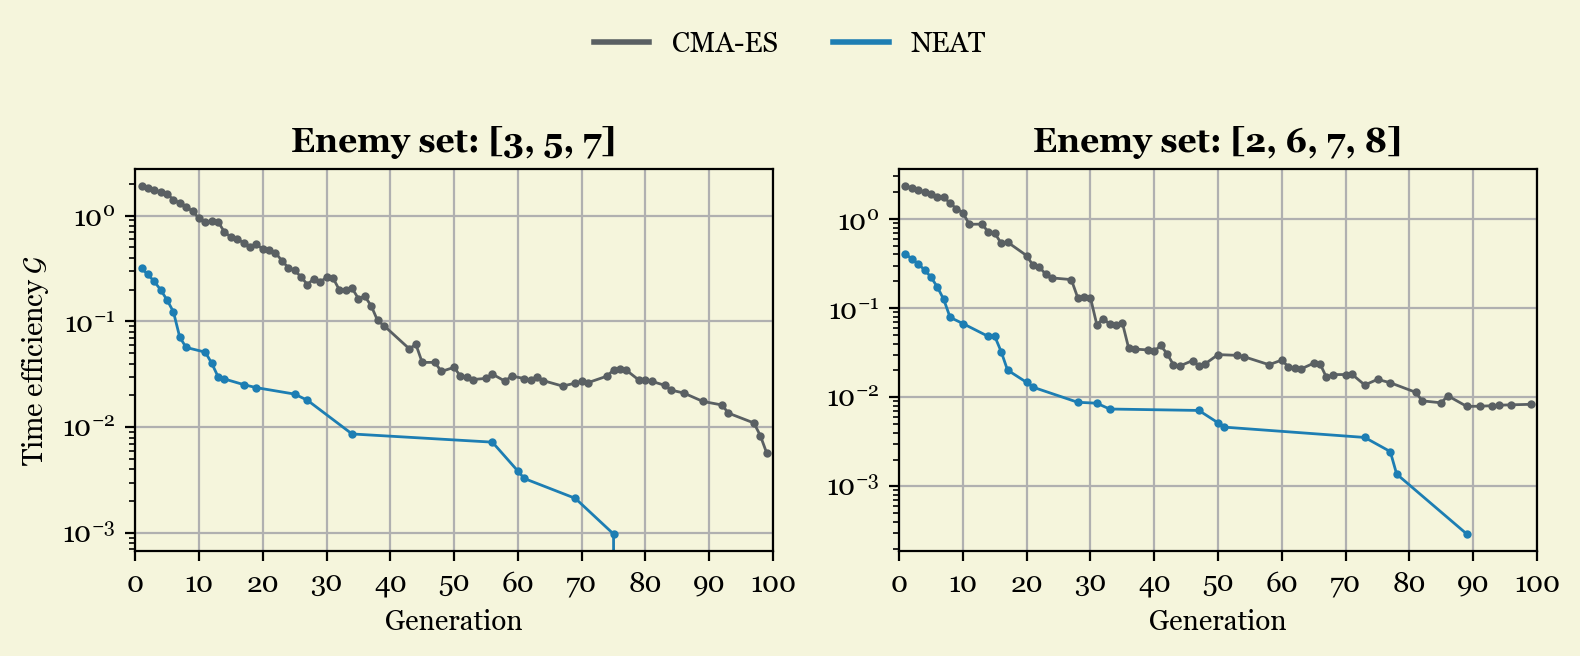

In [23]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=200)
fig.patch.set_facecolor('beige')

# Plot formatting
for (i, enemy_set) in enumerate([ENEMY_SET_1, ENEMY_SET_2]):

    axes[i].set_facecolor('beige')

    if i == 0:
        axes[i].set_ylabel("Time efficiency " + r"$\mathcal{G}$")
        
    axes[i].set_xlim(0, NGEN)
    axes[i].set_xticks(np.arange(0, 101, 10))
    axes[i].set_xlabel("Generation")
    axes[i].set_title(f"Enemy set: {enemy_set}", weight="bold")
    axes[i].set_yscale('log')
    axes[i].grid()

lines = []
labels = []

for (i, enemy_set) in enumerate([ENEMY_SET_1, ENEMY_SET_2]):    
    line1 = axes[i].plot(cmaes_timeeff_plotdata[i][0], cmaes_timeeff_plotdata[i][1], '-o', color="#5a6063", lw=1, ms=2)
    line2 = axes[i].plot(neat_timeeff_plotdata[i][0], neat_timeeff_plotdata[i][1], '-o', color="#1d7eb3", lw=1, ms=2)

# Create custom Line2D objects for the legend
CMA_line = Line2D([0], [0], color="#5a6063", lw=2)
NEAT_line = Line2D([0], [0], color="#1d7eb3", lw=2)

fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.legend(handles=[CMA_line, NEAT_line], labels=["CMA-ES", "NEAT"], loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.10), fontsize=10, frameon=False)
fig.savefig("figures/timeplot.png", dpi=400)
plt.show()

---

#### 3.3. Time efficiency, interpolated and smoothed out

#### Prepare CMAES time efficiency data

In [24]:
# Mean cumulative time
cmaes_mean_cumtime = np.mean(cmaes_cumtime, axis=1)
print(cmaes_mean_cumtime.shape)

# Differences in mean max fitness
cmaes_mean_hof = np.mean(cmaes_hof, axis=1)
cmaes_maxdiff = cmaes_mean_hof - np.roll(cmaes_mean_hof, 1, axis=1)
cmaes_maxdiff[cmaes_maxdiff < 0] = 0
print(cmaes_maxdiff.shape)

cmaes_timeeff_plotdata = []

for i in range(2):
    # Delete entries (generations) where max fitness wasn't changed
    nonzero_indices = np.nonzero(cmaes_maxdiff[i])[0]

    # Interpolate difference in max fitness
    cmaes_maxdiff_interp = np.interp(range(100), nonzero_indices, cmaes_maxdiff[i, nonzero_indices])
    cmaes_maxdiff_interp = savgol_filter(cmaes_maxdiff_interp, 100, 1)
    cmaes_maxdiff_interp[cmaes_maxdiff_interp < 0] = 1e-3

    # Cumulative time difference
    cumtime_diff = cmaes_mean_cumtime[i] - np.roll(cmaes_mean_cumtime[i], 1)
    cumtime_diff[0] = cmaes_mean_cumtime[i, 0]

    # Calculate time efficiency
    time_eff = cmaes_maxdiff_interp / cumtime_diff

    # And smoothen it out
    # yy = savgol_filter(time_eff, 100, 1)
    yy = time_eff
    xx = range(100)

    cmaes_timeeff_plotdata.append([xx, yy])
    print(len(xx), len(yy))

(2, 100)
(2, 100)
100 100
100 100


#### Prepare NEAT time efficiency data

In [25]:
# Mean cumulative time
neat_mean_cumtime = np.mean(neat_cumtime, axis=1)
print(neat_mean_cumtime.shape)

# Differences in mean max fitness
neat_mean_max = np.mean(neat_max, axis=1)
neat_maxdiff = neat_mean_max - np.roll(neat_mean_max, 1, axis=1)
neat_maxdiff[neat_maxdiff < 0] = 0
print(neat_maxdiff.shape)

neat_timeeff_plotdata = []

for i in range(2):
    # Delete entries (generations) where max fitness wasn't changed
    nonzero_indices = np.nonzero(neat_maxdiff[i])[0]

    # Interpolate difference in max fitness
    neat_maxdiff_interp = np.interp(range(100), nonzero_indices, neat_maxdiff[i, nonzero_indices])
    neat_maxdiff_interp = savgol_filter(neat_maxdiff_interp, 100, 1)
    neat_maxdiff_interp[neat_maxdiff_interp < 0] = 1e-3

    # Cumulative time difference
    cumtime_diff = neat_mean_cumtime[i] - np.roll(neat_mean_cumtime[i], 1)
    cumtime_diff[0] = neat_mean_cumtime[i, 0]

    # Calculate time efficiency
    time_eff = neat_maxdiff_interp / cumtime_diff

    # And smoothen it out
    # yy = savgol_filter(time_eff, 100, 1)
    yy = time_eff
    xx = range(100)

    neat_timeeff_plotdata.append([xx, yy])
    print(len(xx), len(yy))

(2, 100)
(2, 100)
100 100
100 100


#### Plotting

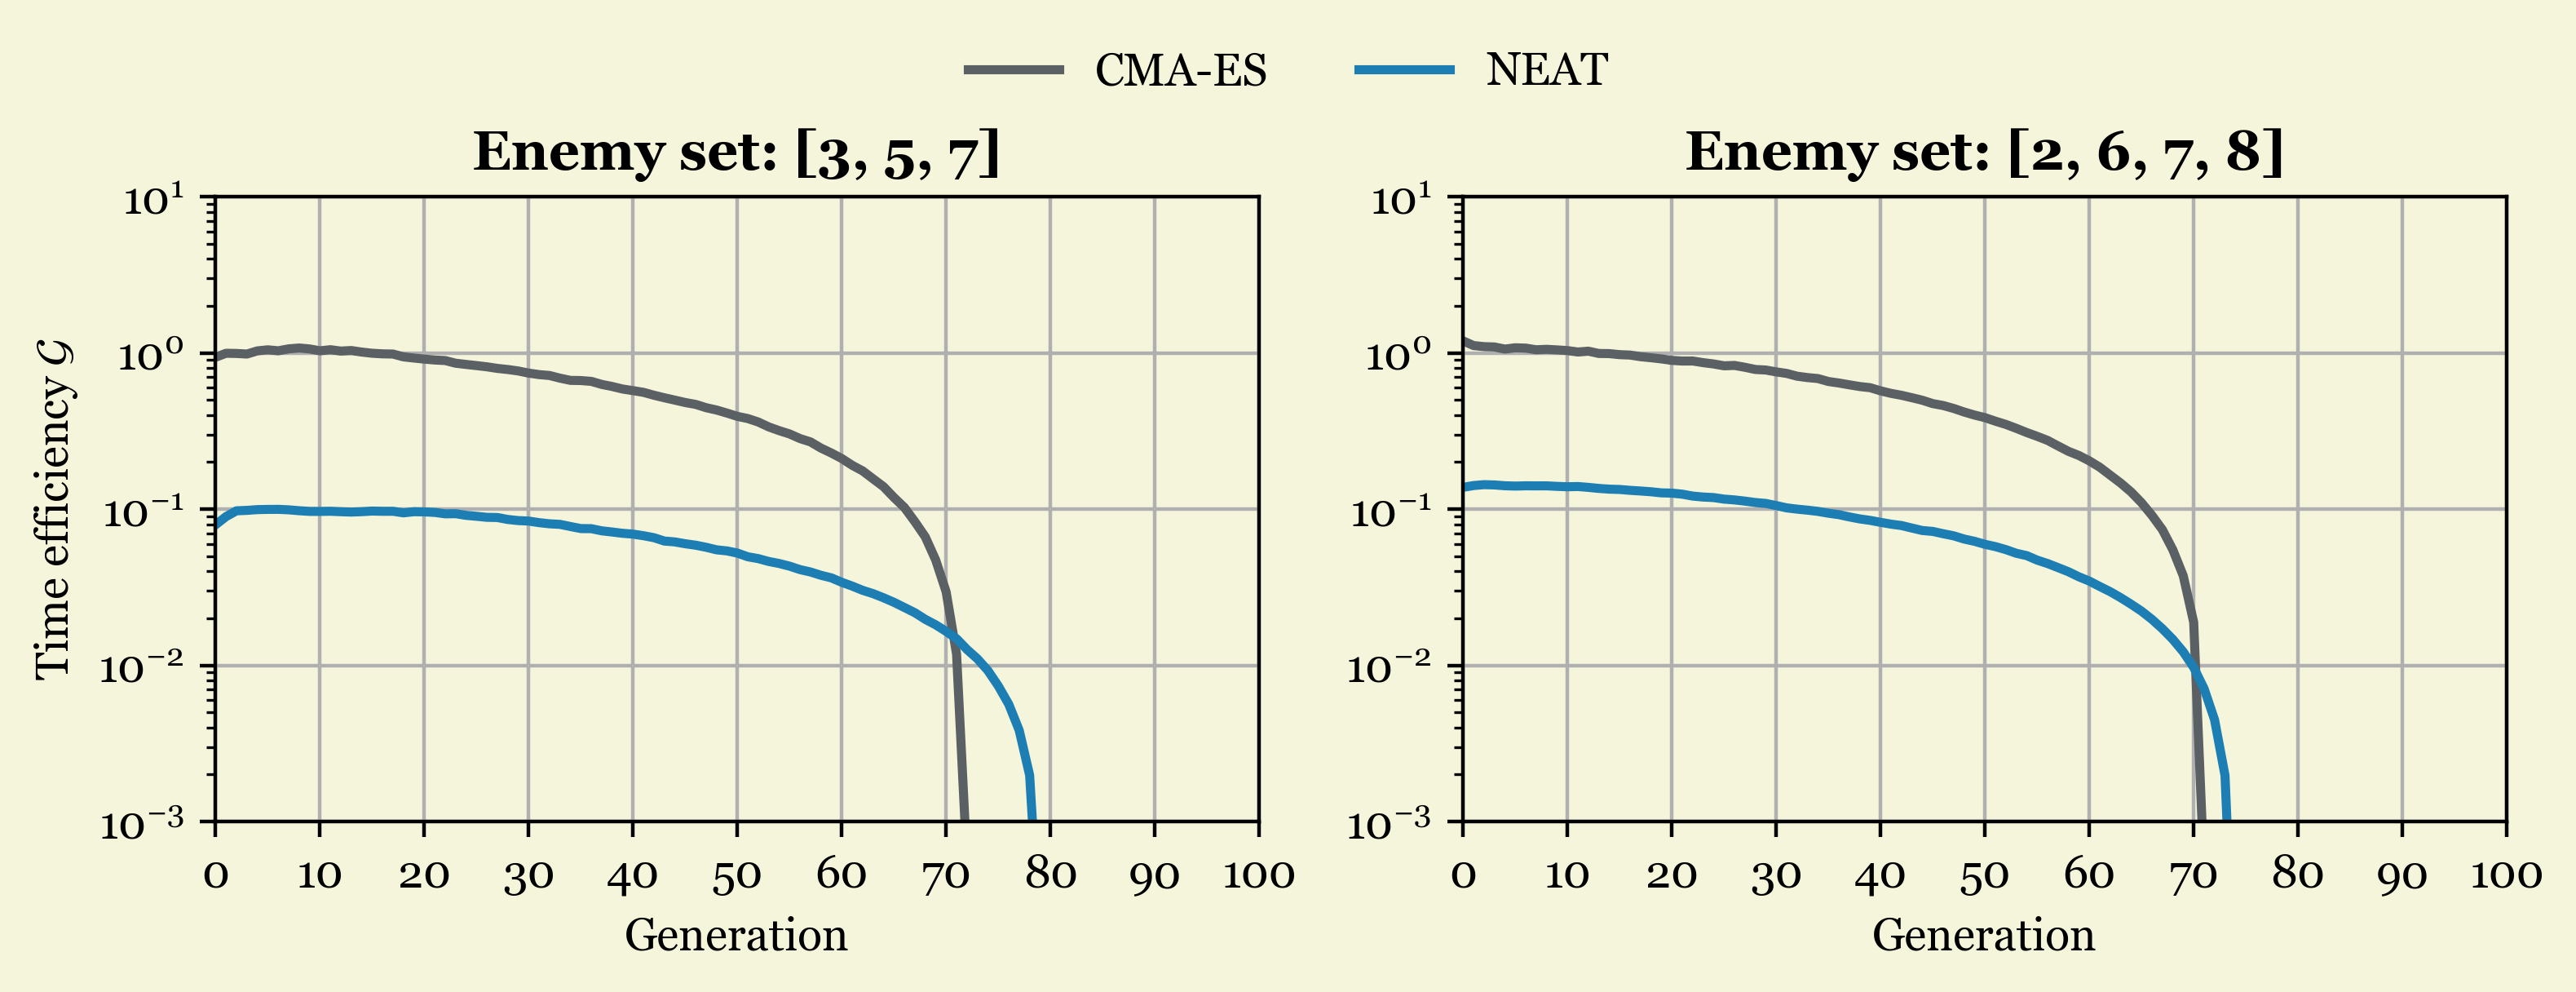

In [30]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=400)
fig.patch.set_facecolor('beige')

# Plot formatting
for (i, enemy_set) in enumerate([ENEMY_SET_1, ENEMY_SET_2]):
    
    axes[i].set_facecolor('beige')

    if i == 0:
        axes[i].set_ylabel("Time efficiency " + r"$\mathcal{G}$")
        
    axes[i].set_xlim(0, 100)
    axes[i].set_xticks(np.arange(0, 101, 10))
    axes[i].set_xlabel("Generation")
    axes[i].set_title(f"Enemy set: {enemy_set}", weight="bold")
    axes[i].set_yscale('log')
    axes[i].set_ylim(1e-3, 1e1)
    axes[i].grid()

lines = []
labels = []

for (i, enemy_set) in enumerate([ENEMY_SET_1, ENEMY_SET_2]):    
    line1 = axes[i].plot(cmaes_timeeff_plotdata[i][0], cmaes_timeeff_plotdata[i][1], color="#5a6063", lw=2)
    line2 = axes[i].plot(neat_timeeff_plotdata[i][0], neat_timeeff_plotdata[i][1], color="#1d7eb3", lw=2)

# Create custom Line2D objects for the legend
CMA_line = Line2D([0], [0], color="#5a6063", lw=2)
NEAT_line = Line2D([0], [0], color="#1d7eb3", lw=2)

fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.legend(handles=[CMA_line, NEAT_line], labels=["CMA-ES", "NEAT"], loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.02), fontsize=10, frameon=False)
fig.savefig("figures/timeplot.png", dpi=400)
plt.show()